In [55]:
####################################################################################################
####################################################################################################
####################################### import libraries ###########################################
####################################################################################################
####################################################################################################

# Standard libraries
import os
import random
import typing as t
from collections import Counter

# Data manipulation
import numpy as np
import polars as pl

# Machine Learning and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Text Processing
from torchtext.data import get_tokenizer
# from nltk.tokenize import TweetTokenizer
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline



In [56]:

####################################################################################################
####################################################################################################
####################################### global variables ###########################################
####################################################################################################
####################################################################################################

# spell=Speller(lang="en", fast=True)
list_of_countries_trigrams = ['AFG', 'RSA', 'ALB', 'ALG', 'GER', 'AND', 'ENG', 'ANG', 'AIA', 'ATG', 'KSA', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT', 'AZE', 'BAH', 'BHR', 'BAN', 'BRB', 'BEL', 'BLZ', 'BEN', 'BER', 'BHU', 'BLR', 'MYA', 'BOL', 'BIH', 'BOT', 'BRA', 'BRU', 'BUL', 'BFA', 'BDI', 'CAM', 'CMR', 'CAN', 'CPV', 'CHI', 'CHN', 'CYP', 'COL', 'COM', 'CGO', 'PRK', 'KOR', 'CRC', 'CIV', 'CRO', 'CUB', 'CUR', 'DEN', 'DJI', 'DMA', 'SCO', 'EGY', 'UAE', 'ECU', 'ERI', 'ESP', 'EST', 'ESW', 'USA', 'ETH', 'FIJ', 'FIN', 'FRA', 'GAB', 'GAM', 'GEO', 'GHA', 'GIB', 'GRE', 'GRN', 'GUA', 'GUM', 'GUI', 'EQG', 'GNB', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'CAY', 'COK', 'FRO', 'SOL', 'TCA', 'VGB', 'VIR', 'IND', 'IDN', 'IRQ', 'IRN', 'IRL', 'NIR', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KGZ', 'KVX', 'KUW', 'LAO', 'LES', 'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MAD', 'MAS', 'MWI', 'MDV', 'MLI', 'MLT', 'MAR', 'MRI', 'MTN', 'MEX', 'MDA', 'MNG', 'MNE', 'MSR', 'MOZ', 'NAM', 'NEP', 'NCA', 'NIG', 'NGA', 'NOR', 'NCL', 'NZL', 'OMA', 'UGA', 'UZB', 'PAK', 'PLE', 'PAN', 'PNG', 'PAR', 'NED', 'WAL', 'PER', 'PHI', 'POL', 'PUR', 'POR', 'QAT', 'COD', 'CTA', 'DOM', 'CZE', 'ROU', 'RUS', 'RWA', 'SKN', 'SMR', 'VIN', 'LCA', 'SLV', 'SAM', 'ASA', 'STP', 'SEN', 'SRB', 'SEY', 'SLE', 'SIN', 'SVK', 'SVN', 'SOM', 'SDN', 'SSD', 'SRI', 'SWE', 'SUI', 'SUR', 'SYR', 'TJK', 'TAH', 'TPE', 'TAN', 'CHA', 'THA', 'TLS', 'TOG', 'TGA', 'TRI', 'TUN', 'TKM', 'TUR', 'UKR', 'URU', 'VAN', 'VEN', 'VIE', 'YEM', 'ZAM', 'ZIM', 'BOE', 'GUF', 'GBR', 'GLP', 'NMI', 'KIR', 'MTQ', 'NIU', 'REU', 'SMN', 'SMA', 'TUV', 'ZAN', 'ALA', 'COR', 'GRL', 'GUE', 'IMA', 'FLK', 'MHL', 'JER', 'MYT', 'FSM', 'MCO', 'PLW', 'EUS', 'ESH', 'BLM', 'SPM', 'SHN', 'VAT', 'WLF']

# Define tokenizer
tokenizer = get_tokenizer("basic_english")
# tokenizer = TweetTokenizer().tokenize

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pl.read_csv(os.path.join(path, filename))
        li.append(df)
    output = pl.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

# Define paths
path_to_data = "../../challenge_data/"
path_to_training_tweets = os.path.join(path_to_data, "train_tweets")
path_to_eval_tweets = os.path.join(path_to_data, "eval_tweets")
output_path = "evaluation_predictions.csv"

In [57]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return item

# Embbedding

In [58]:
# Feature extraction: word frequency per review
def extract_keyword_frequencies(tweets, keywords):
    """
    Extract the frequency of each keyword in a list of tweets.

    Parameters
    ----------
    tweets : list
        List of tweets.
    keywords : list
        List of keywords.

    Returns
    -------
    np.array
        Feature matrix of shape (num_tweets, num_keywords).

    Examples
    --------
    >>> tweets = ['I love this movie!', 'I hate this movie.']
    >>> keywords = ['love', 'hate', 'movie']
    >>> extract_keyword_frequencies(tweets, keywords)
    array([[1, 0, 1],
           [0, 1, 1]])
    """

    feature_matrix = []
    for text in tweets:
        tokens = tokenizer(text)
        token_counts = Counter(tokens)
        frequencies = [token_counts[keyword] for keyword in keywords]
        feature_matrix.append(frequencies)
    return np.array(feature_matrix)/np.sum(np.array(feature_matrix), axis=1, keepdims=True)

def tokenize_texts(texts, vocab, max_len):
    """
    Tokenize and pad/trim texts to create sequences of token indices.
    
    Args:
        texts: List of strings (input texts).
        vocab: Dictionary mapping words to indices.
        max_len: Maximum sequence length.
        
    Returns:
        Tensor of token indices (batch_size, max_len).
    """
    sequences = []
    for text in texts:
        tokens = tokenizer(text)
        token_indices = [vocab.get(token, 0) for token in tokens]  # 0 for unknown tokens
        if len(token_indices) < max_len:
            token_indices.extend([0] * (max_len - len(token_indices)))  # Padding
        else:
            token_indices = token_indices[:max_len]  # Trimming
        sequences.append(token_indices)
    return torch.tensor(sequences, dtype=torch.long)

def build_vocab(texts, max_vocab_size=5000):
    tokens = []
    for text in texts:
        tokens.extend(tokenizer(text))
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(Counter(tokens).most_common(max_vocab_size))}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab



# Definition of the models

In [69]:
class FeedforwardNeuralNetModel(nn.Module):
    ### 
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x
    
# class LSTMModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, num_class, dropout_rate=0.5):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
#         self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True, dropout=dropout_rate)
#         self.fc = nn.Linear(hidden_dim * 2, num_class)
#         self.dropout = nn.Dropout(dropout_rate)
        
#     def forward(self, text):
#         embedded = self.embedding(text)
#         lstm_out, (hidden, _) = self.lstm(embedded)
#         # Concatenate the final forward and backward hidden states
#         hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
#         hidden = self.dropout(hidden)
#         output = self.fc(hidden)
#         return output  # We'll apply sigmoid in the loss function

import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        """
        LSTM Model
        Parameters
        ----------
        input_dim: int
            Number of input features (vocab size or feature size)
        hidden_dim: int
            Number of LSTM hidden units
        num_classes: int
            Number of output classes
        """
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # LSTM output
        output, (hidden, cell) = self.lstm(x)

        # Final hidden state for classification
        hidden = hidden[-1]  # (batch_size, hidden_dim)
        out = self.fc(hidden)
        return torch.sigmoid(out)


In [60]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10, scheduler=None):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        # Scheduler
        if scheduler:
            scheduler.step()
        
        # Training
        model.train()
        train_loss = 0.0


        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [61]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

# FeedForward

In [39]:
# Load and preprocess training data
df_train = load_data(path_to_training_tweets)

print(df_train)

shape: (5_056_050, 6)
┌────────┬─────────┬──────────┬───────────┬───────────────┬─────────────────────────────────┐
│ ID     ┆ MatchID ┆ PeriodID ┆ EventType ┆ Timestamp     ┆ Tweet                           │
│ ---    ┆ ---     ┆ ---      ┆ ---       ┆ ---           ┆ ---                             │
│ str    ┆ i64     ┆ i64      ┆ i64       ┆ i64           ┆ str                             │
╞════════╪═════════╪══════════╪═══════════╪═══════════════╪═════════════════════════════════╡
│ 2_0    ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @soccerdotcom: If #ESP beat… │
│ 2_0    ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ Visit the #SITEP official web … │
│ 2_0    ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @soccerdotcom: If #ESP beat… │
│ 2_0    ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @worldsoccershop: If there … │
│ 2_0    ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @soccerdotcom: If #AUS beat… │
│ …      ┆ …       ┆ …        ┆ …     

In [40]:
MAX_SUBGROUP = 30

# create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
random_id = np.random.randint(0, MAX_SUBGROUP, len(df_train))

# create a new column in df_train with the random integers

df_train = df_train.with_columns([pl.Series("random_id", random_id)])

print(df_train)

shape: (5_056_050, 7)
┌────────┬─────────┬──────────┬───────────┬───────────────┬────────────────────────────┬───────────┐
│ ID     ┆ MatchID ┆ PeriodID ┆ EventType ┆ Timestamp     ┆ Tweet                      ┆ random_id │
│ ---    ┆ ---     ┆ ---      ┆ ---       ┆ ---           ┆ ---                        ┆ ---       │
│ str    ┆ i64     ┆ i64      ┆ i64       ┆ i64           ┆ str                        ┆ i64       │
╞════════╪═════════╪══════════╪═══════════╪═══════════════╪════════════════════════════╪═══════════╡
│ 2_0    ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @soccerdotcom: If #ESP  ┆ 4         │
│        ┆         ┆          ┆           ┆               ┆ beat…                      ┆           │
│ 2_0    ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ Visit the #SITEP official  ┆ 26        │
│        ┆         ┆          ┆           ┆               ┆ web …                      ┆           │
│ 2_0    ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @socce

In [44]:
# Concatenate tweets
df_train_bis = (
    df_train
    .group_by(["ID", "MatchID", "PeriodID", "random_id"])
    .agg([
        pl.col("Tweet").str.concat(" ").alias("Concatenated_Tweets"),
        pl.col("EventType").first().alias("EventType")
    ])
    .sort(["ID", "MatchID", "PeriodID", "random_id"])
).drop("random_id")

print(df_train_bis)


shape: (64_099, 5)
┌──────┬─────────┬──────────┬─────────────────────────────────┬───────────┐
│ ID   ┆ MatchID ┆ PeriodID ┆ Concatenated_Tweets             ┆ EventType │
│ ---  ┆ ---     ┆ ---      ┆ ---                             ┆ ---       │
│ str  ┆ i64     ┆ i64      ┆ str                             ┆ i64       │
╞══════╪═════════╪══════════╪═════════════════════════════════╪═══════════╡
│ 0_0  ┆ 0       ┆ 0        ┆ RT @FOXSoccer: #WorldCup Group… ┆ 0         │
│ 0_0  ┆ 0       ┆ 0        ┆ RT @MNUnitedFC: #WorldCup2014 … ┆ 0         │
│ 0_0  ┆ 0       ┆ 0        ┆ @Nesta_Carter @Wanderers7 abou… ┆ 0         │
│ 0_0  ┆ 0       ┆ 0        ┆ The more goals France scores t… ┆ 0         │
│ 0_0  ┆ 0       ┆ 0        ┆ RT @trueSCRlife: If #Shaqiri s… ┆ 0         │
│ …    ┆ …       ┆ …        ┆ …                               ┆ …         │
│ 8_99 ┆ 8       ┆ 99       ┆ RT @EASPORTSFIFA: .@neymarjr s… ┆ 1         │
│ 8_99 ┆ 8       ┆ 99       ┆ RT @braza_29: Let's go brazill… ┆ 1    

In [45]:
tweets = df_train_bis["Concatenated_Tweets"].to_list()

print(np.mean([len(t) for t in tweets]))

6961.490350863508


In [46]:
# Split into train and test for cross-validation
train, test = train_test_split(df_train_bis, test_size=0.3, random_state=1337)

# Build vocabulary
words = []
for text in train['Concatenated_Tweets']:
    words.extend(tokenizer(text))
number_of_words_in_dict = 5000
vocab = dict(Counter(words).most_common(number_of_words_in_dict))
keywords = list(vocab.keys())

train_X = extract_keyword_frequencies(train['Concatenated_Tweets'], keywords)
test_X = extract_keyword_frequencies(test['Concatenated_Tweets'], keywords)

# Standardize the feature matrix
scaler = StandardScaler() 
train_X = scaler.fit_transform(train_X) # train_X -> (train_X - mean(train_X)) / std(train_X)
test_X = scaler.transform(test_X)

# Labels
train_y = np.array(train['EventType']).reshape(-1, 1)
test_y = np.array(test['EventType']).reshape(-1, 1)

# %%
# Create TensorDatasets and DataLoaders
batch_size = 64

trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


Epoch 1/10, Train Loss: 0.4686, Val Loss: 0.4158, Val Accuracy: 0.7991
Epoch 2/10, Train Loss: 0.3547, Val Loss: 0.4136, Val Accuracy: 0.8060
Epoch 3/10, Train Loss: 0.2905, Val Loss: 0.4332, Val Accuracy: 0.8082
Epoch 4/10, Train Loss: 0.2363, Val Loss: 0.4811, Val Accuracy: 0.8093
Epoch 5/10, Train Loss: 0.1916, Val Loss: 0.5557, Val Accuracy: 0.8097
Epoch 6/10, Train Loss: 0.1567, Val Loss: 0.6275, Val Accuracy: 0.8116
Epoch 7/10, Train Loss: 0.1345, Val Loss: 0.6709, Val Accuracy: 0.8094
Epoch 8/10, Train Loss: 0.1169, Val Loss: 0.7561, Val Accuracy: 0.8133
Epoch 9/10, Train Loss: 0.1059, Val Loss: 0.8100, Val Accuracy: 0.8138
Epoch 10/10, Train Loss: 0.0953, Val Loss: 0.8768, Val Accuracy: 0.8123


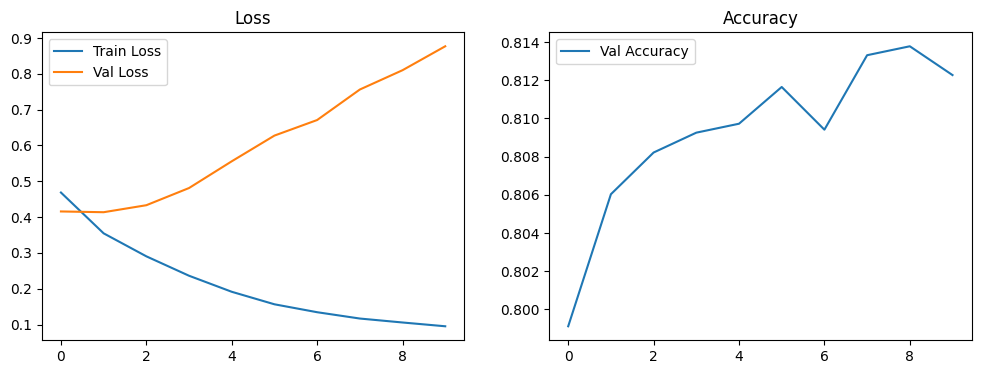

In [47]:
# Hyperparameters
input_dim = train_X.shape[1]
hidden_dim = 64
output_dim = 1  # Binary classification

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
history = train_model(model, train_loader, test_loader, optimizer, criterion)

# Plot training history
plot_history(history)


In [43]:
# Load and preprocess the evaluation dataset
df_eval = load_data(path_to_eval_tweets)

print(df_eval)

# Group and concatenate tweets in the evaluation dataset
df_eval_bis = (
    df_eval
    .group_by(["ID", "MatchID", "PeriodID"])
    .agg([
        pl.col("Tweet").str.concat(" ").alias("Concatenated_Tweets")
    ])
    .sort(["ID", "MatchID", "PeriodID"])
)

print(df_eval_bis)

# Extract features for the evaluation dataset
eval_X = extract_keyword_frequencies(df_eval_bis['Concatenated_Tweets'], keywords)
# Standardize the features using the scaler fitted on the training data
eval_X = scaler.transform(eval_X)

# Create a DataLoader for the evaluation dataset
evalset = TensorDataset(torch.tensor(eval_X, dtype=torch.float32))
eval_loader = DataLoader(evalset, batch_size=batch_size, shuffle=False)

# Predict on the evaluation dataset
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for inputs in eval_loader:
        inputs = inputs[0].to(device)  # Remove extra dimension from TensorDataset
        outputs = model(inputs)
        predicted = (outputs > 0.5).float().cpu().numpy()
        predictions.extend(predicted)

# Flatten predictions to match the required output format
predictions = np.array(predictions, dtype=int).flatten()

# Save predictions to a CSV file
df_eval_bis = df_eval_bis.with_columns(
    pl.Series("EventType", predictions)
)

df_eval_bis.select(["ID", "EventType"]).write_csv(output_path)
print(f"Predictions saved to {output_path}")


shape: (1_072_928, 5)
┌───────┬─────────┬──────────┬───────────────┬─────────────────────────────────┐
│ ID    ┆ MatchID ┆ PeriodID ┆ Timestamp     ┆ Tweet                           │
│ ---   ┆ ---     ┆ ---      ┆ ---           ┆ ---                             │
│ str   ┆ i64     ┆ i64      ┆ i64           ┆ str                             │
╞═══════╪═════════╪══════════╪═══════════════╪═════════════════════════════════╡
│ 6_0   ┆ 6       ┆ 0        ┆ 1403376600000 ┆ I Finally get to see Germany p… │
│ 6_0   ┆ 6       ┆ 0        ┆ 1403376600000 ┆ RT @Wor1dCup2014: If Any of th… │
│ 6_0   ┆ 6       ┆ 0        ┆ 1403376600000 ┆ Fascinated for this #GERvsGHA … │
│ 6_0   ┆ 6       ┆ 0        ┆ 1403376600000 ┆ : #GER and #GHA in a few.       │
│ 6_0   ┆ 6       ┆ 0        ┆ 1403376600000 ┆ BOATENG GRUDGE MATCH: 21/2 for… │
│ …     ┆ …       ┆ …        ┆ …             ┆ …                               │
│ 9_129 ┆ 9       ┆ 129      ┆ 1403647200000 ┆ RT @xja_mila: Ivory coast didn… │
│ 9_12

# Test on LSTM

In [70]:
df_train = load_data(path_to_training_tweets)

MAX_SUBGROUP = 30
# Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
random_id = np.random.randint(0, MAX_SUBGROUP, len(df_train))

# Create a new column in df_train with the random integers
df_train = df_train.with_columns([pl.Series("random_id", random_id)])

# Concatenate tweets
df_train_bis = (
    df_train
    .group_by(["ID", "MatchID", "PeriodID", "random_id"])
    .agg([
        pl.col("Tweet").str.concat(" ").alias("Concatenated_Tweets"),
        pl.col("EventType").first().alias("EventType")
    ])
    .sort(["ID", "MatchID", "PeriodID", "random_id"])
).drop("random_id")

# print(df_train)
print(df_train_bis)


shape: (64_090, 5)
┌──────┬─────────┬──────────┬─────────────────────────────────┬───────────┐
│ ID   ┆ MatchID ┆ PeriodID ┆ Concatenated_Tweets             ┆ EventType │
│ ---  ┆ ---     ┆ ---      ┆ ---                             ┆ ---       │
│ str  ┆ i64     ┆ i64      ┆ str                             ┆ i64       │
╞══════╪═════════╪══════════╪═════════════════════════════════╪═══════════╡
│ 0_0  ┆ 0       ┆ 0        ┆ Its time for                    ┆ 0         │
│      ┆         ┆          ┆ #SUI vs #HON                    ┆           │
│      ┆         ┆          ┆ #…                              ┆           │
│ 0_0  ┆ 0       ┆ 0        ┆ RT @rogerfederer: Playing tomo… ┆ 0         │
│ 0_0  ┆ 0       ┆ 0        ┆ RT @trueSCRlife: If #Shaqiri s… ┆ 0         │
│ 0_0  ┆ 0       ┆ 0        ┆ #ECU must match or better #SUI… ┆ 0         │
│ 0_0  ┆ 0       ┆ 0        ┆ RT @Kristen_Dileo: Honduras be… ┆ 0         │
│ …    ┆ …       ┆ …        ┆ …                               ┆ …    

In [71]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from collections import Counter
from transformers import BertTokenizer

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Build vocabulary
words = []
for text in train['Concatenated_Tweets']:
    words.extend(tokenizer.tokenize(text))
number_of_words_in_dict = 5000
vocab = dict(Counter(words).most_common(number_of_words_in_dict))
keywords = list(vocab.keys())

# Extract keyword frequencies (Feature-based input)
train_X = extract_keyword_frequencies(train['Concatenated_Tweets'], keywords)
test_X = extract_keyword_frequencies(test['Concatenated_Tweets'], keywords)

# Standardize feature matrices
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

# Labels
train_y = np.array(train['EventType']).reshape(-1, 1)
test_y = np.array(test['EventType']).reshape(-1, 1)

# Create DataLoaders
batch_size = 64
trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

KeyboardInterrupt: 

In [ ]:
# Hyperparameters
input_dim = train_X.shape[1]  # Feature dimension
hidden_dim = 64
output_dim = 1  # Binary classification

# Model
model = LSTMModel(input_dim, hidden_dim, output_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10):
    history = {"loss": [], "val_loss": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        # Log losses
        history["loss"].append(running_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(test_loader))

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}")

    return history

# Train the model
history = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10)

TypeError: LSTMModel.__init__() got an unexpected keyword argument 'use_embedding'

In [ ]:
# Load evaluation data
df_eval = load_data(path_to_eval_tweets)

# Preprocess evaluation data
df_eval_bis = (
    df_eval
    .group_by(["ID", "MatchID", "PeriodID"])
    .agg([pl.col("Tweet").str.concat(" ").alias("Concatenated_Tweets")])
    .sort(["ID", "MatchID", "PeriodID"])
)

# Extract keyword frequencies for evaluation
eval_X = extract_keyword_frequencies(df_eval_bis['Concatenated_Tweets'], keywords)
eval_X = scaler.transform(eval_X)  # Standardize evaluation data

# Create DataLoader for evaluation
evalset = TensorDataset(torch.tensor(eval_X, dtype=torch.float32))
eval_loader = DataLoader(evalset, batch_size=batch_size, shuffle=False)

# Predict
model.eval()
predictions = []
with torch.no_grad():
    for inputs in eval_loader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        predictions.extend((outputs > 0.5).float().cpu().numpy())

# Flatten predictions
predictions = np.array(predictions, dtype=int).flatten()

# Save predictions
df_eval_bis = df_eval_bis.with_columns(
    pl.Series("EventType", predictions)
)
df_eval_bis.select(["ID", "EventType"]).write_csv(output_path)
print(f"Predictions saved to {output_path}")

Predictions saved to evaluation_predictions.csv
